<img src = "https://github.com/VeryFatBoy/notebooks/blob/main/common/images/img_github_singlestore-jupyter_featured_2.png?raw=true">

<div id="singlestore-header" style="display: flex; background-color: rgba(235, 249, 245, 0.25); padding: 5px;">
    <div id="icon-image" style="width: 90px; height: 90px;">
        <img width="100%" height="100%" src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/header-icons/browser.png" />
    </div>
    <div id="text" style="padding: 5px; margin-left: 10px;">
        <div id="badge" style="display: inline-block; background-color: rgba(0, 0, 0, 0.15); border-radius: 4px; padding: 4px 8px; align-items: center; margin-top: 6px; margin-bottom: -2px; font-size: 80%">SingleStore Notebooks</div>
        <h1 style="font-weight: 500; margin: 8px 0 0 4px;">Using SingleStore, Spark and Alternating Least Squares (ALS) to Build a Movie Recommender System</h1>
    </div>
</div>

In [3]:
!pip cache purge --quiet

In [6]:
!conda install -y --quiet -c conda-forge openjdk=8

Solving environment: ...working... done

# All requested packages already installed.



In [7]:
!pip install matplotlib --quiet
!pip install pyspark --quiet
!pip install wordcloud --quiet

In [8]:
import array, binascii
import io
import matplotlib.pyplot as plt
import os
import requests
import urllib3
import zipfile

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import udf
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from singlestoredb.management import get_secret
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [9]:
os.makedirs("jars", exist_ok = True)

In [10]:
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

def download_and_extract_zip(url, extract_to, verify = True):
    response = requests.get(url, verify = verify)
    if response.status_code == 200:
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            z.extractall(extract_to)
        print(f"Zip file from '{url}' downloaded and unpacked successfully to '{extract_to}'")
    else:
        print(f"Failed to download the zip file from '{url}'")

urls = [
    "https://github.com/babu-thomas/movielens-posters/files/3513037/ml-1m.zip",
    # Backup "https://github.com/VeryFatBoy/workshop/raw/main/posters/ml-1m.zip",
    "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
    # Backup "https://github.com/VeryFatBoy/workshop/raw/main/datasets/ml-1m.zip"
]

extract_dirs = [
    "posters",
    "datasets"
]

for url, extract_dir in zip(urls, extract_dirs):
    verify = not url.startswith("https://files.grouplens.org")
    download_and_extract_zip(url, extract_dir, verify)

Zip file from 'https://github.com/babu-thomas/movielens-posters/files/3513037/ml-1m.zip' downloaded and unpacked successfully to 'posters'
Zip file from 'https://files.grouplens.org/datasets/movielens/ml-1m.zip' downloaded and unpacked successfully to 'datasets'


In [12]:
def download_jar(url, destination):
    response = requests.get(url)
    with open(destination, "wb") as f:
        f.write(response.content)

jar_urls = [
    ("https://repo1.maven.org/maven2/com/singlestore/singlestore-jdbc-client/1.2.4/singlestore-jdbc-client-1.2.4.jar", "jars/singlestore-jdbc-client-1.2.4.jar"),
    ("https://repo1.maven.org/maven2/com/singlestore/singlestore-spark-connector_2.12/4.1.8-spark-3.5.0/singlestore-spark-connector_2.12-4.1.8-spark-3.5.0.jar", "jars/singlestore-spark-connector_2.12-4.1.8-spark-3.5.0.jar"),
    ("https://repo1.maven.org/maven2/org/apache/commons/commons-dbcp2/2.12.0/commons-dbcp2-2.12.0.jar", "jars/commons-dbcp2-2.12.0.jar"),
    ("https://repo1.maven.org/maven2/org/apache/commons/commons-pool2/2.12.0/commons-pool2-2.12.0.jar", "jars/commons-pool2-2.12.0.jar"),
    ("https://repo1.maven.org/maven2/io/spray/spray-json_3/1.3.6/spray-json_3-1.3.6.jar", "jars/spray-json_3-1.3.6.jar")
]

for url, destination in jar_urls:
    download_jar(url, destination)

print("JAR files downloaded successfully")

JAR files downloaded successfully


In [13]:
# Create a Spark session
spark = (SparkSession
             .builder
             .config("spark.jars", ",".join([destination for _, destination in jar_urls]))
             .appName("Spark Movie Recommender")
             .getOrCreate()
        )

spark.sparkContext.setLogLevel("ERROR")

24/10/10 07:44:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [14]:
separator = "::"

movies_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("title", StringType(), True),
    StructField("genres", StringType(), True)
])

In [15]:
movies_df = spark.read.csv(
    "datasets/ml-1m/movies.dat",
    header = False,
    schema = movies_schema,
    sep = separator
)

In [16]:
movies_df.show(5)

+---+--------------------+--------------------+
| id|               title|              genres|
+---+--------------------+--------------------+
|  1|    Toy Story (1995)|Animation|Childre...|
|  2|      Jumanji (1995)|Adventure|Childre...|
|  3|Grumpier Old Men ...|      Comedy|Romance|
|  4|Waiting to Exhale...|        Comedy|Drama|
|  5|Father of the Bri...|              Comedy|
+---+--------------------+--------------------+
only showing top 5 rows



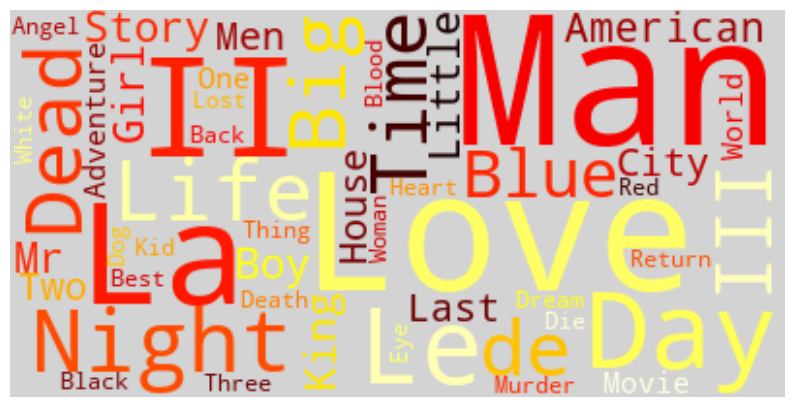

In [17]:
movie_titles = movies_df.select("title").collect()
movie_titles_list = [movie_titles[i][0] for i in range(len(movie_titles))]
movie_titles_corpus = (" ").join(title for title in movie_titles_list)

wordcloud = WordCloud(
    stopwords = STOPWORDS,
    background_color = "lightgrey",
    colormap = "hot",
    max_words = 50,
    # collocations = False,
).generate(movie_titles_corpus)

plt.figure(figsize = (10, 8))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [18]:
posters_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("poster", StringType(), True),
])

In [19]:
posters_df = spark.read.csv(
    "posters/ml-1m/movie_poster.csv",
    header = False,
    schema = posters_schema
)

In [20]:
movies_df = movies_df.join(
    posters_df,
    ["id"]
)

In [21]:
movies_df.show(5)

+---+--------------------+--------------------+--------------------+
| id|               title|              genres|              poster|
+---+--------------------+--------------------+--------------------+
|  1|    Toy Story (1995)|Animation|Childre...|https://m.media-a...|
|  2|      Jumanji (1995)|Adventure|Childre...|https://m.media-a...|
|  3|Grumpier Old Men ...|      Comedy|Romance|https://m.media-a...|
|  4|Waiting to Exhale...|        Comedy|Drama|https://m.media-a...|
|  5|Father of the Bri...|              Comedy|https://m.media-a...|
+---+--------------------+--------------------+--------------------+
only showing top 5 rows



In [22]:
users_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("gender", StringType(), True),
    StructField("age", IntegerType(), True),
    StructField("occupation_id", IntegerType(), True),
    StructField("zip_code", StringType(), True)
])

In [23]:
users_df = spark.read.csv(
    "datasets/ml-1m/users.dat",
    header = False,
    schema = users_schema,
    sep = separator
)

In [24]:
users_df.show(5)

+---+------+---+-------------+--------+
| id|gender|age|occupation_id|zip_code|
+---+------+---+-------------+--------+
|  1|     F|  1|           10|   48067|
|  2|     M| 56|           16|   70072|
|  3|     M| 25|           15|   55117|
|  4|     M| 45|            7|   02460|
|  5|     M| 25|           20|   55455|
+---+------+---+-------------+--------+
only showing top 5 rows



In [25]:
(users_df
    .groupBy("gender")
    .count()
    .show()
)

+------+-----+
|gender|count|
+------+-----+
|     F| 1709|
|     M| 4331|
+------+-----+



In [26]:
occupations = [
    ( 0, "other"),
    ( 1, "academic/educator"),
    ( 2, "artist"),
    ( 3, "clerical/admin"),
    ( 4, "college/grad student"),
    ( 5, "customer service"),
    ( 6, "doctor/health care"),
    ( 7, "executive/managerial"),
    ( 8, "farmer"),
    ( 9, "homemaker"),
    (10, "K-12 student"),
    (11, "lawyer"),
    (12, "programmer"),
    (13, "retired"),
    (14, "sales/marketing"),
    (15, "scientist"),
    (16, "self-employed"),
    (17, "technician/engineer"),
    (18, "tradesman/craftsman"),
    (19, "unemployed"),
    (20, "writer")
]

occupations_schema = StructType([
    StructField("occupation_id", IntegerType(), True),
    StructField("occupation", StringType(), True)
])

In [27]:
occupations_df = spark.createDataFrame(
    data = occupations,
    schema = occupations_schema
)

In [28]:
users_df = users_df.join(
    occupations_df,
    ["occupation_id"]
)

users_df = users_df.drop(
    "occupation_id"
)

In [29]:
users_df.show(5)

+----+------+---+--------+----------+
|  id|gender|age|zip_code|occupation|
+----+------+---+--------+----------+
|6039|     F| 45|   01060|     other|
|6031|     F| 18|   45123|     other|
|6023|     M| 25|   43213|     other|
|6019|     M| 25|   10024|     other|
|6010|     M| 35|   79606|     other|
+----+------+---+--------+----------+
only showing top 5 rows



In [30]:
(users_df
    .groupBy("occupation")
    .count()
    .orderBy("count", ascending = False)
    .show(21)
)

+--------------------+-----+
|          occupation|count|
+--------------------+-----+
|college/grad student|  759|
|               other|  711|
|executive/managerial|  679|
|   academic/educator|  528|
| technician/engineer|  502|
|          programmer|  388|
|     sales/marketing|  302|
|              writer|  281|
|              artist|  267|
|       self-employed|  241|
|  doctor/health care|  236|
|        K-12 student|  195|
|      clerical/admin|  173|
|           scientist|  144|
|             retired|  142|
|              lawyer|  129|
|    customer service|  112|
|           homemaker|   92|
|          unemployed|   72|
| tradesman/craftsman|   70|
|              farmer|   17|
+--------------------+-----+



In [31]:
ratings_schema = StructType([
    StructField("user_id", IntegerType(), True),
    StructField("movie_id", IntegerType(), True),
    StructField("rating", IntegerType(), True),
    StructField("timestamp", IntegerType(), True)
])

In [32]:
ratings_df = spark.read.csv(
    "datasets/ml-1m/ratings.dat",
    header = False,
    schema = ratings_schema,
    sep = separator
)

In [33]:
ratings_df.show(5)

+-------+--------+------+---------+
|user_id|movie_id|rating|timestamp|
+-------+--------+------+---------+
|      1|    1193|     5|978300760|
|      1|     661|     3|978302109|
|      1|     914|     3|978301968|
|      1|    3408|     4|978300275|
|      1|    2355|     5|978824291|
+-------+--------+------+---------+
only showing top 5 rows



In [34]:
(ratings_df
    .describe("user_id", "movie_id", "rating")
    .show()
)

+-------+------------------+------------------+------------------+
|summary|           user_id|          movie_id|            rating|
+-------+------------------+------------------+------------------+
|  count|           1000209|           1000209|           1000209|
|   mean| 3024.512347919285|1865.5398981612843| 3.581564453029317|
| stddev|1728.4126948999715|1096.0406894572482|1.1171018453732606|
|    min|                 1|                 1|                 1|
|    max|              6040|              3952|                 5|
+-------+------------------+------------------+------------------+



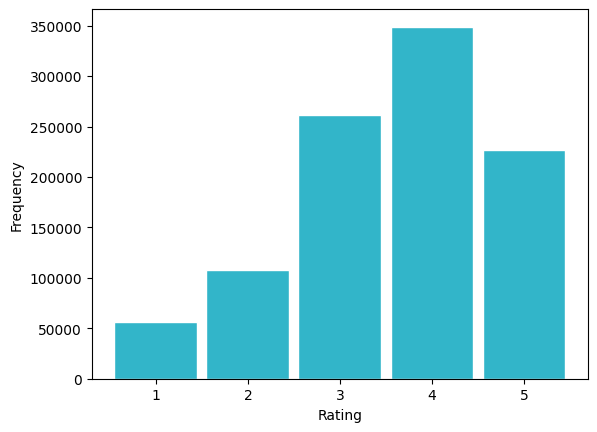

In [35]:
movie_ratings = ratings_df.select("rating").collect()
movie_ratings_list = [movie_ratings[i][0] for i in range(len(movie_ratings))]

plt.hist(
    movie_ratings_list,
    edgecolor = "white",
    color = "#32B5C9",
    rwidth = 0.9,
    bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
)

plt.ylabel("Frequency")
plt.xlabel("Rating")
plt.show()

In [36]:
(train, test) = ratings_df.randomSplit([0.7, 0.3], seed = 123)

In [37]:
als = ALS(
    maxIter = 5,
    regParam = 0.01,
    userCol = "user_id",
    itemCol = "movie_id",
    ratingCol = "rating",
    coldStartStrategy = "drop",
    seed = 0
)

model = als.fit(train)

In [38]:
predictions = model.transform(test)

predictions.show(5)

+-------+--------+------+---------+----------+
|user_id|movie_id|rating|timestamp|prediction|
+-------+--------+------+---------+----------+
|    148|       1|     5|977335193| 4.3501983|
|    148|       2|     5|979578366| 3.8232098|
|    148|      11|     5|977334939| 4.3217063|
|    148|      50|     2|979577217| 3.8569243|
|    148|      60|     3|979578136| 3.6407182|
+-------+--------+------+---------+----------+
only showing top 5 rows



In [39]:
re = RegressionEvaluator(
    predictionCol = "prediction",
    labelCol = "rating",
    metricName = "rmse"
)

rmse = re.evaluate(predictions)
print(rmse)

0.914789148011371


In [40]:
model.userFactors.show(5) # show(5, False) to show the whole column

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[0.8803474, 0.799...|
| 20|[0.47382098, 0.65...|
| 30|[0.8101257, -0.38...|
| 40|[-0.008799153, 0....|
| 50|[-0.3301647, 0.45...|
+---+--------------------+
only showing top 5 rows



In [41]:
model.itemFactors.show(5) # show(5, False) to show the whole column

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[0.08083679, 0.60...|
| 20|[0.5918954, 0.415...|
| 30|[-0.047557518, -0...|
| 40|[-1.0247109, 1.19...|
| 50|[0.1312179, -0.08...|
+---+--------------------+
only showing top 5 rows



In [42]:
user_factors_df = model.userFactors
item_factors_df = model.itemFactors

In [43]:
# Create StringIndexer for users and fit to the ratings data
user_indexer = StringIndexer(
    inputCol = "user_id",
    outputCol = "userIndex"
).fit(ratings_df)
ratings_with_user_index = user_indexer.transform(ratings_df)

# Create StringIndexer for movies and fit to the ratings data
movie_indexer = StringIndexer(
    inputCol = "movie_id",
    outputCol = "movieIndex"
).fit(ratings_df)
ratings_with_movie_index = movie_indexer.transform(ratings_with_user_index)

# Select the distinct user and movie mappings
user_id_mapping_df = ratings_with_movie_index.select("user_id", "userIndex").distinct()
movie_id_mapping_df = ratings_with_movie_index.select("movie_id", "movieIndex").distinct()

In [44]:
# Join user_factors with the original user_id using the userIndex mapping
user_factors_with_original_id = user_factors_df.join(
    user_id_mapping_df,
    user_factors_df.id == user_id_mapping_df.userIndex,
    "inner"
)

# Drop the internal 'id' column and userIndex
user_factors_with_original_id = user_factors_with_original_id.drop(user_factors_df.id).drop("userIndex")

# Rename 'user_id' to 'id'
user_factors_with_original_id = user_factors_with_original_id.withColumnRenamed("user_id", "id")

# Show the result
user_factors_with_original_id.show(5)

+--------------------+----+
|            features|  id|
+--------------------+----+
|[0.18641779, 0.41...| 102|
|[0.2795305, 1.372...| 231|
|[0.13990341, 0.31...| 595|
|[0.5334203, -0.31...| 736|
|[1.6251956, 0.628...|1061|
+--------------------+----+
only showing top 5 rows



In [45]:
# Join item_factors with the original movie_id using the movieIndex mapping
item_factors_with_original_id = item_factors_df.join(
    movie_id_mapping_df,
    item_factors_df.id == movie_id_mapping_df.movieIndex,
    "inner"
)

# Drop the internal 'id' column and movieIndex
item_factors_with_original_id = item_factors_with_original_id.drop(item_factors_df.id).drop("movieIndex")

# Rename 'movie_id' to 'id'
item_factors_with_original_id = item_factors_with_original_id.withColumnRenamed("movie_id", "id")

# Show the result
item_factors_with_original_id.show(5)

+--------------------+----+
|            features|  id|
+--------------------+----+
|[0.13229367, 0.08...| 920|
|[0.6062423, -0.11...|2004|
|[-0.49494815, -0....|1300|
|[-0.09910057, 0.7...| 297|
|[0.31136423, 0.00...|  59|
+--------------------+----+
only showing top 5 rows



In [46]:
def vector_to_hex(vector):
    vector_bytes = bytes(array.array("f", vector))
    vector_hex = binascii.hexlify(vector_bytes)
    vector_string = str(vector_hex.decode())
    return vector_string

vector_to_hex = udf(vector_to_hex, StringType())
spark.udf.register("vector_to_hex", vector_to_hex)

In [47]:
user_factors_df = user_factors_with_original_id.withColumn(
    "factors",
    vector_to_hex("features")
)

item_factors_df = item_factors_with_original_id.withColumn(
    "factors",
    vector_to_hex("features")
)

In [48]:
users = users_df.join(
    user_factors_df,
    ["id"]
)

users = users.drop("features")

In [49]:
users.show(5)

+----+------+---+--------+--------------------+--------------------+
|  id|gender|age|zip_code|          occupation|             factors|
+----+------+---+--------+--------------------+--------------------+
| 471|     M| 35|   08904|executive/managerial|fb61ac3fe841733f5...|
| 833|     M| 35|   46825|executive/managerial|974bed3ba914db3e6...|
| 148|     M| 50|   57747| technician/engineer|4d60b43fc42ada3e1...|
|1088|     F|  1|   98103|        K-12 student|2e3a7dbee69fb0be6...|
| 496|     M| 18|   55455|college/grad student|d3e09f3e1b0413bf3...|
+----+------+---+--------+--------------------+--------------------+
only showing top 5 rows



In [50]:
movies = movies_df.join(
    item_factors_df,
    ["id"]
)

movies = movies.drop("features")

In [51]:
movies.show(5)

+----+--------------------+-----------------+--------------------+--------------------+
|  id|               title|           genres|              poster|             factors|
+----+--------------------+-----------------+--------------------+--------------------+
| 920|Gone with the Win...|Drama|Romance|War|https://m.media-a...|fe77073ece5ca63dc...|
|2004|Gremlins 2: The N...|    Comedy|Horror|https://m.media-a...|b2321b3fc9a5ecbde...|
|1300|My Life as a Dog ...|            Drama|https://m.media-a...|d869fdbe0056b3bc9...|
| 297|      Panther (1995)|            Drama|https://m.media-a...|3df5cabd23593f3f1...|
|  59|Confessional, The...|    Drama|Mystery|https://m.media-a...|226b9f3e87c5033c6...|
+----+--------------------+-----------------+--------------------+--------------------+
only showing top 5 rows



<div class="alert alert-block alert-warning">
    <b class="fa fa-solid fa-exclamation-circle"></b>
    <div>
        <p><b>Action Required</b></p>
        <p>Select the database from the drop-down menu at the top of this notebook. It updates the <b>connection_url</b> which is used by SQLAlchemy to make connections to the selected database.</p>
    </div>
</div>

In [52]:
from sqlalchemy import *

db_connection = create_engine(connection_url)
url = db_connection.url

In [53]:
password = get_secret("password")
host = url.host
port = url.port
cluster = host + ":" + str(port)

In [54]:
spark.conf.set("spark.datasource.singlestore.ddlEndpoint", cluster)
spark.conf.set("spark.datasource.singlestore.user", "admin")
spark.conf.set("spark.datasource.singlestore.password", password)
spark.conf.set("spark.datasource.singlestore.disablePushdown", "false")

In [55]:
(users.write
    .format("singlestore")
    .option("loadDataCompression", "LZ4")
    .mode("overwrite")
    .save("recommender_db.users")
)

In [56]:
(movies.write
    .format("singlestore")
    .option("loadDataCompression", "LZ4")
    .mode("overwrite")
    .save("recommender_db.movies")
)

In [57]:
spark.stop()